# Problema del flujo máximo a coste mínimo
**Pablo García Pérez**

En este cuaderno Jupyter, abordaremos el Problema de Asignación, más concretamente el Problema del flujo máximo a coste mínimo. Además, se proporcionarán algunos supuestos que ayudarán a contextualizar y comprender estas variantes, siendo estos uno para cada uno de los problemas.

## ¿Qué es?
El problema de flujo máximo a coste mínimo es un problema de optimización en teoría de grafos que busca encontrar el flujo de mayor valor posible entre un nodo de origen y un nodo de destino en una red, minimizando al mismo tiempo el costo total asociado a ese flujo.

## Modelo
Una empresa eléctrica encargada de abastecer la zona norte de Tenerife se enfrentaba a un importante reto operativo. La subestación principal que suministraba energía a La Victoria de Acentejo estaba al borde de su capacidad, lo que había provocado interrupciones frecuentes en el servicio y numerosas quejas por parte de los residentes de la región.  
En contraposición, otra subestación ubicada en La Laguna disponía de bastante energía, suficiente para cubrir las necesidades de La Victoria. Sin embargo, el traslado de esta energía no era una tarea sencilla, ya que las líneas de transmisión entre ambas zonas tenían un límite estricto de capacidad, cuyo incumplimiento podría ocasionar daños graves a la infraestructura.  
Para encontrar una solución, se presentó un informe técnico detallado que incluía un mapa de la red de transmisión. La evaluación de esta información resultaba esencial para diseñar un plan que garantizara el suministro eléctrico de manera eficiente y sin comprometer la integridad de las líneas.

## Datos

Para agrupar los diferentes municipios de Tenerife, a los cuales llamaremos en este caso nodos, estableceremos un conjunto \( V = \{1, 2, \dots, n\} \). En este esquema, consideraremos que el nodo 4 corresponde a La Laguna, que será el punto de origen o nodo fuente, mientras que el nodo final, o sumidero, será el nodo 1, correspondiente a La Victoria.

Para modelar el flujo de energía entre estos municipios, creamos una matriz \( C \), donde cada posición \( C[i][j] \) indique el límite máximo de voltios que las líneas de transmisión permiten entre el municipio \( i \) y el municipio \( j \).

Adicionalmente, para evaluar los costos asociados al transporte de energía, generamos una matriz \( W \), donde cada posición \( W[i][j] \) representa el costo unitario de transmitir un determinado volumen de energía desde el municipio \( i \) al municipio \( j \). Si no existe una conexión previa, y se requiere construir una nueva línea, asignamos a \( W[i][j] \) un valor muy alto \( M \), indicando el elevado costo asociado a esta operación.

Con esta representación, podemos analizar cómo distribuir de manera eficiente el excedente de energía desde La Laguna hacia La Victoria, considerando tanto las restricciones de capacidad de las líneas existentes como los costos de transmisión. Esta información será esencial para implementar un modelo que optimice el flujo de energía y garantice un suministro adecuado en toda la red.

## Resolvemos el modelo

Definimos cada parte en diferentes secciones para poder explicar en detalle lo que se está haciendo en cada sección del código.

### Importamos las librerías necesarias para que pueda funcionar el código
Estas instrucciones configuran el entorno para modelar y resolver problemas de optimización matemática utilizando **JuMP** como herramienta de modelado y **GLPK** como solucionador. Además, incluyen funciones para añadir gráficos usando **GraphRecipes** y también **Plots y Graphs**



In [82]:
# Importa el gestor de paquetes de Julia
import Pkg

# Paquetes necesarios para este proyecto.
Pkg.add("JuMP")
Pkg.add("GLPK")
Pkg.add("Graphs")
Pkg.add("GraphRecipes")
Pkg.add("Plots")

# Importa los módulos necesarios para trabajar con grafos, gráficos y optimización.
using GraphRecipes  # Para visualizaciones avanzadas de grafos.
using Plots         # Para la creación de gráficos.
using Graphs        # Para la creación y manipulación de grafos.

# Importa los módulos necesarios para optimización matemática y otras utilidades.
using JuMP          # Para modelar problemas de optimización.
using GLPK          # Como solver de optimización lineal y entera.
using Random        # Para la generación de números aleatorios (útil en simulaciones).
using Test          # Para escribir y ejecutar pruebas unitarias.
using LinearAlgebra # Para realizar operaciones algebraicas lineales.


   Resolving package versions...
  No Changes to `C:\Users\pablo\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\pablo\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\pablo\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\pablo\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\pablo\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\pablo\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\pablo\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\pablo\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\pablo\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\pablo\.julia\environments\v1.11\Manifest.toml`


### Definimos las matrices
Configuramos los datos iniciales para el problema, definiendo las matrices que representan la capacidad y los costes de las conexiones entre los nodos. También se establece cual de los nodos es el incial, y cual es el final

- **Matriz de capacidades (`Cmax`)**:  
  Representa la capacidad máxima de flujo entre nodos en un grafo dirigido. Cada posición \( C[i][j] \) indica cuánto flujo puede pasar directamente desde el nodo \( i \) al nodo \( j \).  
  Un valor de `0` indica que no existe una conexión directa entre esos nodos.

- **Matriz de costos (`Costs`)**:  
  Representa el costo asociado a transferir flujo entre nodos. Cada posición \( Costs[i][j] \) indica el costo unitario de mover flujo desde el nodo \( i \) al nodo \( j \).  
  Un valor de `0` significa que no hay un costo porque no existe conexión directa.

In [208]:
 # Definir las matrices Cmax y Costs con los valores modificados
 Cmax = [
     0 75 0 0 0 0 0 0 0 0;
     0 0 0 0 0 0 0 0 0 0;
     0 88 0 0 0 0 100 0 0 0;
     0 0 60 0 0 0 0 0 0 0;
     0 0 0 115 0 100 0 0 0 0;
     0 0 90 0 0 0 120 0 0 0;
     0 0 0 0 0 0 0 45 0 0;
     0 80 0 0 0 0 0 0 70 0;
     85 0 0 0 0 0 0 0 0 95;
     60 0 0 0 0 0 0 0 0 0
 ]
 
 Costs = [
     0 10 0 0 0 0 0 0 0 0;
     0 0 0 0 0 0 0 0 0 0;
     0 6 0 0 0 0 12 0 0 0;
     0 0 8 0 0 0 0 0 0 0;
     0 0 0 5 0 6 0 0 0 0;
     0 0 3 0 0 0 10 0 0 0;
     0 0 0 0 0 0 0 6 0 0;
     0 4 0 0 0 0 0 0 11 0;
     9 0 0 0 0 0 0 0 0 4;
     4 0 0 0 0 0 0 0 0 0
 ]
 
 # Nodo inicial y final
 s = 4  # Nodo inicial es 4
 t = 1  # Nodo final es 1
 
 # Número de nodos
 n = size(Cmax, 1)

 println("El nodo inicial es: ", s)
 println("El nodo final es: ", t)
 println("El conjunto de nodos tiene |V|= ", n, " nodos")

 

El nodo inicial es: 4
El nodo final es: 1
El conjunto de nodos tiene |V|= 10 nodos


### Establecemos la función para generar el grafo

Con la función **plot_graph** podemos generar el grafo que se establece usando las matrices anteiores. Dando un mejor entendimiento a la vez de poder visualizar el grafo que hemos establecido. Mostrando las conexciones entre ellos además de los costes y la capacidad máxima

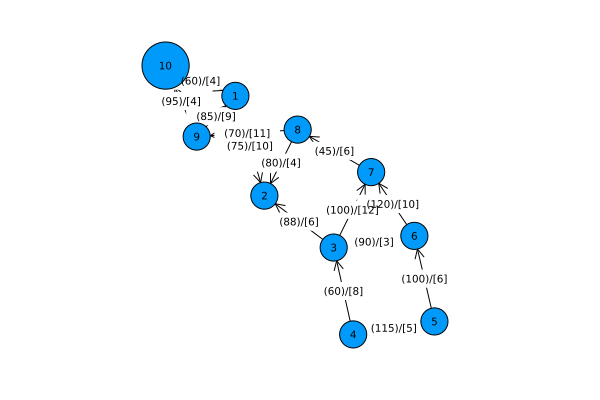

In [209]:
function plot_graph(capacities, costs)
    # Crear un diccionario para almacenar las etiquetas de los bordes
    edge_labels = Dict()
    
    # Crear una matriz de etiquetas de bordes, inicializada como vacío
    edge_matrix = Array{String}(undef, n, n)
    
    # Recorrer todos los nodos para generar las etiquetas de cada borde
    for start_node in 1:n
        for end_node in 1:n
            # Obtener la capacidad y el costo del borde entre los nodos
            edge_capacity = capacities[start_node, end_node]
            edge_cost = costs[start_node, end_node]
            
            # Formatear la etiqueta del borde y almacenarla
            edge_label = string("($edge_capacity)/[$edge_cost]")
            edge_matrix[start_node, end_node] = edge_labels[(start_node, end_node)] = edge_label
        end
    end
    
    # Convertir la matriz de etiquetas en un vector
    label_vector = edge_matrix[:]
    
    # Crear el gráfico con los parámetros configurados
    graphplot(capacities, names=1:n, edgelabel=edge_labels, node_dists=1000, curvature_scalar=0, nodeshape=:circle, nodesize=0.3)
end

# Llamada a la función con las matrices modificadas
plot_graph(Cmax, Costs)


In [210]:
M = 10000000
Costs[t,s] = -M
Cmax[t,s] = M

10000000

### Construimos el modelo

In [211]:
model = Model(GLPK.Optimizer)
set_silent(model)

# Definir variables
@variable(model, x[1:n,1:n] >= 0)

# Definir función objetivo
@objective(model, Min, sum(Costs[i,j] * x[i,j] for i in 1:n, j in 1:n ))

# Definir restricciones
for i in 1:n
        for j in 1:n
                if Cmax[i, j] > 0
                        @constraint(model, x[i, j] <= Cmax[i, j])
                else
                        set_upper_bound(x[i,j], 0)
                end
        end
end


@constraint(model, c[i = 1:n],  sum(x[i, :])  - sum(x[:, i]) == 0)
optimize!(model)
objetive = objective_value(model) + value(x[t, s]) * M
println("Coste mínimo: ", objetive, " €")

println("Corriente máxima: ", value(x[t, s]), " Kw")

println("Corriente por los cable: ")
for i in 1:n  
    cable = false
    text = "  Cable de tensión $i\n"
    for j in 1:n
        if value(x[i, j]) > 0 && i != t && j != s
            cable = true
            text = string(text, "    Flujo en el cable $i->$j: ", value(x[i, j]), "kw, coste ", Costs[i, j] * value(x[i, j]), "€.", "Coste por kilovátio: ", Costs[i, j], "\n")
        end
    end
    if cable
        println(text)
    end
end

Coste mínimo: 2025.0 €
Corriente máxima: 45.0 Kw
Corriente por los cable: 
  Cable de tensión 3
    Flujo en el cable 3->7: 45.0kw, coste 540.0€.Coste por kilovátio: 12

  Cable de tensión 4
    Flujo en el cable 4->3: 45.0kw, coste 360.0€.Coste por kilovátio: 8

  Cable de tensión 7
    Flujo en el cable 7->8: 45.0kw, coste 270.0€.Coste por kilovátio: 6

  Cable de tensión 8
    Flujo en el cable 8->9: 45.0kw, coste 495.0€.Coste por kilovátio: 11

  Cable de tensión 9
    Flujo en el cable 9->10: 45.0kw, coste 180.0€.Coste por kilovátio: 4

  Cable de tensión 10
    Flujo en el cable 10->1: 45.0kw, coste 180.0€.Coste por kilovátio: 4



### Flujo máximo de coste mínimo

In [184]:
# Definir un número grande para penalizar el flujo no permitido
BigNumber = 100000000

# Nueva matriz de capacidades (Cmax)
capacityMatrix = [
    0 6 0 3 0;
    0 0 5 0 3;
    0 0 0 0 7;
    0 0 3 0 6;
    BigNumber 0 0 0 0;
]

# Nueva matriz de costos (Costs)
costMatrix = [
    0 2 0 4 0;
    0 0 2 0 5;
    0 0 0 0 2;
    0 0 3 0 5;
    -BigNumber 0 0 0 0;
]

# Nodo de inicio y nodo de destino
startNode = 1
endNode = 5

# Número de nodos en la red (dimensión de la matriz)
numNodes = size(capacityMatrix, 1)

# Crear el gráfico con las matrices de capacidad y costo
graph(capacityMatrix, costMatrix)

# Crear el modelo de optimización con el optimizador GLPK
model = Model(GLPK.Optimizer)
set_silent(model)  # Silenciar los mensajes del optimizador

# Definir las variables de flujo entre nodos (flujo no negativo)
@variable(model, flow[1:numNodes, 1:numNodes] >= 0)

# Función objetivo: minimizar el costo total del flujo
@objective(model, Min, sum(costMatrix[i, j] * flow[i, j] for i in 1:numNodes, j in 1:numNodes))

# Definir las restricciones de capacidad: el flujo no puede exceder la capacidad
for i in 1:numNodes
    for j in 1:numNodes
        if capacityMatrix[i, j] > 0
            # Si hay capacidad, establecer la restricción de flujo máximo
            @constraint(model, flow[i, j] <= capacityMatrix[i, j])
        else
            # Si no hay capacidad, asegurarse de que el flujo sea cero
            set_upper_bound(flow[i, j], 0)
        end
    end
end

# Definir la restricción de flujo balanceado: flujo entrante igual al flujo saliente para cada nodo
@constraint(model, balanceConstraint[i = 1:numNodes], sum(flow[i, :]) - sum(flow[:, i]) == 0)

# Resolver el modelo de optimización
optimize!(model)

# Calcular el coste total, añadiendo la penalización por flujo en el arco (t, s)
objectiveValue = objective_value(model) + value(flow[endNode, startNode]) * BigNumber
println("Costo mínimo: ", objectiveValue)

# Mostrar el flujo máximo, que es el valor del flujo entre los nodos de destino y origen
println("Flujo máximo: ", value(flow[endNode, startNode]))

# Imprimir los flujos en los arcos donde el flujo es positivo
println("Flujos en los arcos:")
for i in 1:numNodes  
    # Variable para indicar si hay flujo en el nodo
    hasFlow = false
    # Texto que describe el nodo actual
    nodeDetails = "  Nodo $i\n"
    
    # Recorrer los posibles arcos desde el nodo i
    for j in 1:numNodes
        if value(flow[i, j]) > 0 && i != endNode && j != startNode
            # Si hay flujo en el arco y no es el nodo de inicio ni el de destino
            hasFlow = true
            # Añadir detalles sobre el flujo en el arco i -> j
            nodeDetails *= "    Flujo en el arco $i->$j: $(value(flow[i, j])), coste $(costMatrix[i, j] * value(flow[i, j])), coste unitario: $(costMatrix[i, j])\n"
        end
    end
    
    # Si se encontró algún flujo en los arcos de este nodo, imprimir los detalles
    if hasFlow
        println(nodeDetails)
    end
end


Costo mínimo: 64.0
Flujo máximo: 9.0
Flujos en los arcos:
  Nodo 1
    Flujo en el arco 1->2: 6.0, coste 12.0, coste unitario: 2
    Flujo en el arco 1->4: 3.0, coste 12.0, coste unitario: 4

  Nodo 2
    Flujo en el arco 2->3: 5.0, coste 10.0, coste unitario: 2
    Flujo en el arco 2->5: 1.0, coste 5.0, coste unitario: 5

  Nodo 3
    Flujo en el arco 3->5: 5.0, coste 10.0, coste unitario: 2

  Nodo 4
    Flujo en el arco 4->5: 3.0, coste 15.0, coste unitario: 5

